<a href="https://colab.research.google.com/github/joycemegumi/joycemegumi.github.io/blob/master/Copy_of_Image_Recognizer_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Tutorial 1: Build an Image Recognizer on your dataset in less than 10 minutes

This tutorial is a concise step-by-step guide for building and training an Image Recognizer on **any** image dataset of your choice.<br>

In this tutorial, you will learn how to:

- Scrape images from Google Images and create your own dataset
- Build and train an image recognizer on your dataset
- Visualize and adequately interpret classification results
- Test model with new images

**To run this notebook, you can simply open it with Google Colab [here](https://colab.research.google.com/github/SalChem/Fastai-iNotes-iTutorials/blob/master/Image_Recognizer_Tutorial.ipynb).**

<br>Once in Colab, **make sure to change the following to enable GPU backend,** <br>
> Runtime -> Change runtime type -> Hardware Accelerator -> GPU

### Let's start...

## 1. Image Dataset Download and Setup

**Option 1:** Working with a ready dataset of your own

If you would like to use your own image dataset for this tutorial, rearrange it in a way that images of the same class are under the same folder. Then, name the folders with the corresponding class labels.

**Option 2:** Scraping images from Google Images

If you do not have a dataset in-hand, you can scrape images from [Google Images](https://www.google.com/imghp?hl=en) and make up a dataset of your choice. In order to do so, simply install [Fatkun Batch Download Image](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf) extension on your google chrome browser and download any set of google images by clicking the extension tab. Place all images of the same class under the same folder and name it accordingly with the class label.  

**Option 3:** Working with my Monkeys dataset, which I originally scraped from Google Images :)

The dataset can be downloaded and untarred using the following couple bash commands.

In [ ]:
%%capture
!wget "https://www.dropbox.com/s/35ithckx6vqryob/Monkeys_Faces_Dataset.tar?dl=0" -O Monkeys_Faces_Dataset.tar  
!tar --warning=no-unknown-keyword -xzf Monkeys_Faces_Dataset.tar

In this tutorial, we will be classifying **Monkeys**, so we created 6 folders corresponding to 6 different types of monkeys, as shown below.<br><br>

<img width="186" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56703803-5c9b9e80-66bf-11e9-8341-67873c896afb.png">


If you choose to run this notebook with your dataset, simply replace the url and file name in the above cell with yours. Storing the .tar file in Dropbox worked best for me.


## 2. Image Recognition

**For a further explanation of the code and functions used within this notebook, check out my other post: [Concise Notes on Image Recognition, Fastai 2019 v3 Lesson 1](https://nbviewer.jupyter.org/github/SalChem/Fastai-iNotes-iTutorials/blob/master/Image_Recognition_Basics.ipynb?flush_cache=true)**

### Initialization

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
bs = 64  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
PATH = './Monkeys Faces/'

PATH is the path containing all the class folders. You may keep './Monkeys Faces' if you are using Monkeys dataset. Otherwise, specify the path of your folders.

Let's retrieve the image classes,

In [ ]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes)            

There are  6 classes:
 ['Chimpanzee', 'Gorilla', 'Orungatun', 'Macaque', 'Gibbon', 'Mandrill']


Let's verify there are not any corrupt images that cannot be read. If found any, they will simply be deleted.

In [ ]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: Chimpanzee


Class: Gorilla


Class: Orungatun


Class: Macaque


Class: Gibbon


Class: Mandrill


### Creating and training the classifier

Let's split our dataset to 80% for training and 20% for validation,

In [ ]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)

In [ ]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 268 training images and 67 validation images.


Let's visualize some images from different classes,

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

Let's build our Deep Convolutional Neural Network (CNN),

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


The CNN architecture used here is [ResNet34](https://arxiv.org/pdf/1512.03385.pdf). ResNet architecture has had great success within the last few years and still considered state-of-the-art, so I believe there is great value in discussing it a bit. If you are interested solely in getting the Image Recognizer to work, feel free to skip the next few paragraphs.

First, what’s CNN again? We can think of a Convolutional Neural Network (CNN or convNet) as a list of layers that transform the image volume into an output volume, which can be a class score as it is the case in this tutorial. For an in-depth read, I would highly recommend [Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/) from Stanford’s CS231 class.

What is special about ResNet architecture is how it tackles _the degradation problem_ most common in deep networks, where the model accuracy gets saturated and then degrades rapidly. It is important to note here that although some assume that the core idea behind ResNets is overcoming the notorious _vanishing gradient problem_, where gradients get infinitely small as they back-propagate to earlier layers of the network, this is not quite true. 

Resnet architecture introduces an "identity shortcut connection" or often referred to as a "skip connection", which skips one or more layers. The shortcut connections simply perform identity mappings, and their outputs are added to
the outputs of the stacked layers, as shown in the figure below. The skip function creates what is known as a residual block, F(x) in our figure, and that's where the name Residual Nets (ResNets) came from.  

<img width="286" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853841-f6429600-68e1-11e9-9cf3-a2ca324c277b.png">

Comprehensive empirical evidence has shown that the addition of these identity mappings allows the model to go deeper without degradation in performance and such networks are easier to optimize than plain stacked layers. There are several variants of ResNets, such as ResNet50, ResNet101, ResNet152; the number represents the number of layers (depth) of the ResNet. 

<img width="216" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853787-5e44ac80-68e1-11e9-9750-e9f5e417cf1e.png">

Image credit: [ResNet34](https://arxiv.org/pdf/1512.03385.pdf)

In this tutorial, we are using ResNet34. Feel free to try any of the other ResNet models by simply replacing `models.resnet34` by `models.resnet50` for instance, but bare in mind that increasing the number of layers would require more GPU memory.

Let's now pick the appropriate learning rate parameter,

Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


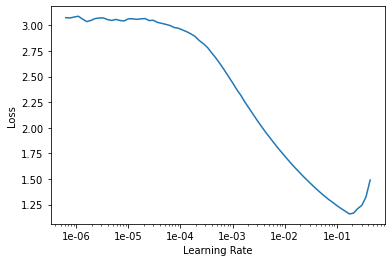

In [ ]:
learn.lr_find();
learn.recorder.plot()

Use the above plot to pick adequate learning rates for your model. We need two learning rates since we are using [cyclic learning rates](https://arxiv.org/pdf/1506.01186.pdf):

- The first learning rate is just before the loss starts to increase, preferably 10x smaller than the rate at which the loss starts to increase. For instance, 1e-02 for our Monkeys dataset. 

- The second learning rate is 10x smaller than the first learning rate, so 1e-03 in our example.

The plot will be different for your dataset, so make sure to pick these two learning rates accordingly.

<br>Replace your chosen learning rates in the **slice** function below and let's train the model.

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.767810,0.773987,0.805970,00:13
1,0.922566,0.113700,0.970149,00:12
2,0.615760,0.056930,0.970149,00:12
3,0.460735,0.056002,0.970149,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Great, we achieved a high classification accuracy with only a few lines of code and without much tuning of the parameters.

We are DONE but let's further interpret the results.

## 3. Results Interpretation and Visualization

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

We can start by visualizing a confusion matrix. The diagonal elements represent the number of images for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier.

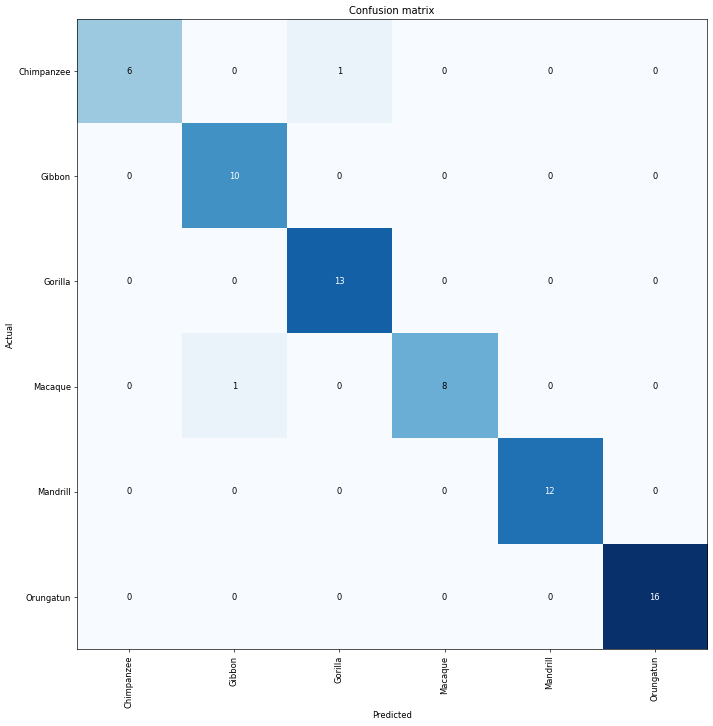

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can also plot images with top losses; in other words, the images that the model was most confused about. A high loss implies high confidence about the wrong answer. 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

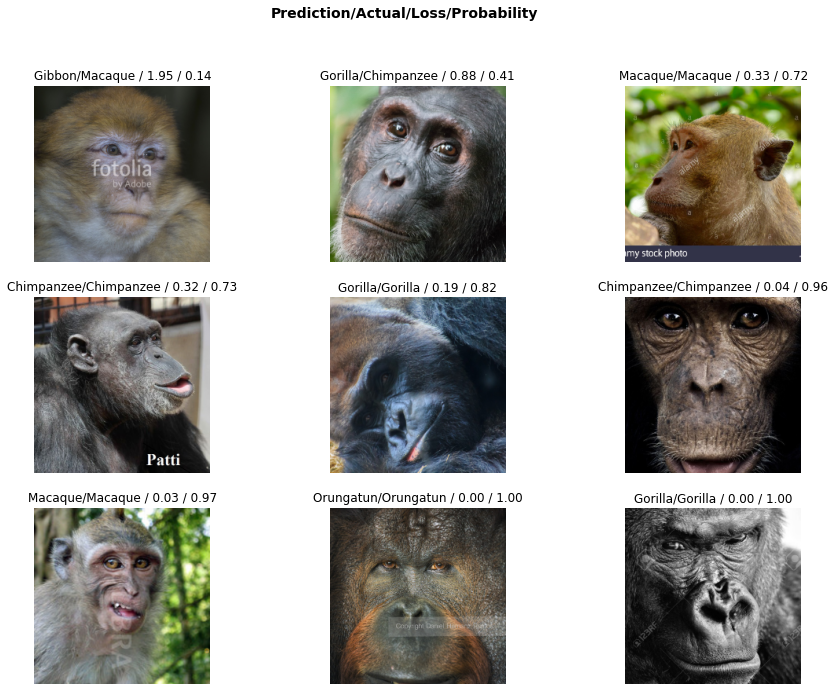

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Images are shown along with top losses:<br> 
prediction label / actual label / loss / probability of actual image class.

#### Congratulations! You have successfully built an Image Recognizer on your own dataset. 

## 4. Testing the model on a new image

Let's now feed the model a new image it never seen before and see how well it classifies it. 

Upload the image to the same folder of this notebook.

In [ ]:
path = './' #The path of your test image
img = open_image(get_image_files(path)[0])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("It is a", pred_class)

IndexError: ignored

### Great job completing, reading, or skimming through this tutorial. 

**Acknowledgment:** This tutorial uses [fastai library](https://docs.fast.ai/index.html), so we thank Jeremy Howard and [fast.ai](https://www.fast.ai/).

If you found this tutorial useful, please follow me on [Medium](https://towardsdatascience.com/https-medium-com-drchemlal-deep-learning-tutorial-1-f94156d79802) for more and send few claps :)